In [1]:
'''
CIV utility functions
'''
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import norm

In [63]:
def est_civ(S, L, T, threshold=0.001, max_steps=100, civ_guess=0.3, max_civ=1.5, verbose=False):
    '''
    estimates stw given current CIV, L, T
    params:
    - S (n): spread-to-worst
    - L (n): leverage
    - T (n): time to takeout
    - max_steps (int): max number of iterations
    - civ_guess (float): initial guess used for all CIV
    - verbose (bool) verbosity
    returns:
    - CIV (n): credit implied volatility
    '''
    step = 0
    CIV = np.full(S.shape, civ_guess)
    while True:
        if step >= max_steps:
            # terminate after max steps taken
            break
        t = np.sqrt(T)
        # d1 = 0.5*CIV*t - ln(l)/(CIV*t)
        # d2 = d1 - CIV*t
        # stw_est = -ln(phi2+(1-phi1)/L)/T
        d1 = 0.5*CIV*t - np.log(L)/(CIV*t)
        d2 = d1-CIV*t
        phi1 = norm.cdf(d1)
        phi2 = norm.cdf(d2)
        S1 = -np.log(np.clip(phi2+(1-phi1)/L, 0.001, None))/T
        err = S1-S
        
        if (np.abs(err) <= threshold).sum() == err.shape[0]:
            # terminate if all err below threshold
            break
    
        # step forward civ estimate
        # dciv = coef*(df1+df2)
        # civ1 = civ0-err/dciv
        coef = -1/(T*(phi2+(1-phi1)/L))
        df1 = -norm.pdf(d1)*(np.log(L)/(CIV**2*t)+0.5*t)/L
        df2 = norm.pdf(d2)*(np.log(L)/(CIV**2*t)-0.5*t)
        dciv = coef*(df1+df2)
        CIV = np.clip(CIV-err/dciv, None, max_civ)
        CIV[np.isnan(CIV)] = max_civ
        step += 1
    
    if verbose:
        print(f'CIV estimate steps: {step}')

    return CIV

In [64]:
S = np.array([0.0096439])
L = np.array([0.279033])
T = np.array([8.7562])
est_civ(S, L, T)

array([0.3396761])

In [65]:
# load data from csv
data_url = 'civ_data.csv'
df = pd.read_csv(data_url)
df.head()

,ISSUANCE,STW,T,L
0,FUN 5.375% due 2024,0.057893,3.663889,0.520688
1,FUN 5.25% due 2029,0.051507,8.786111,0.520688
2,FUN 5.375% due 2027,0.050944,6.536111,0.520688
3,SIX 4.875% due 2024,0.066869,3.830556,0.504090
4,SIX 7% due 2025,0.051011,4.747222,0.504090


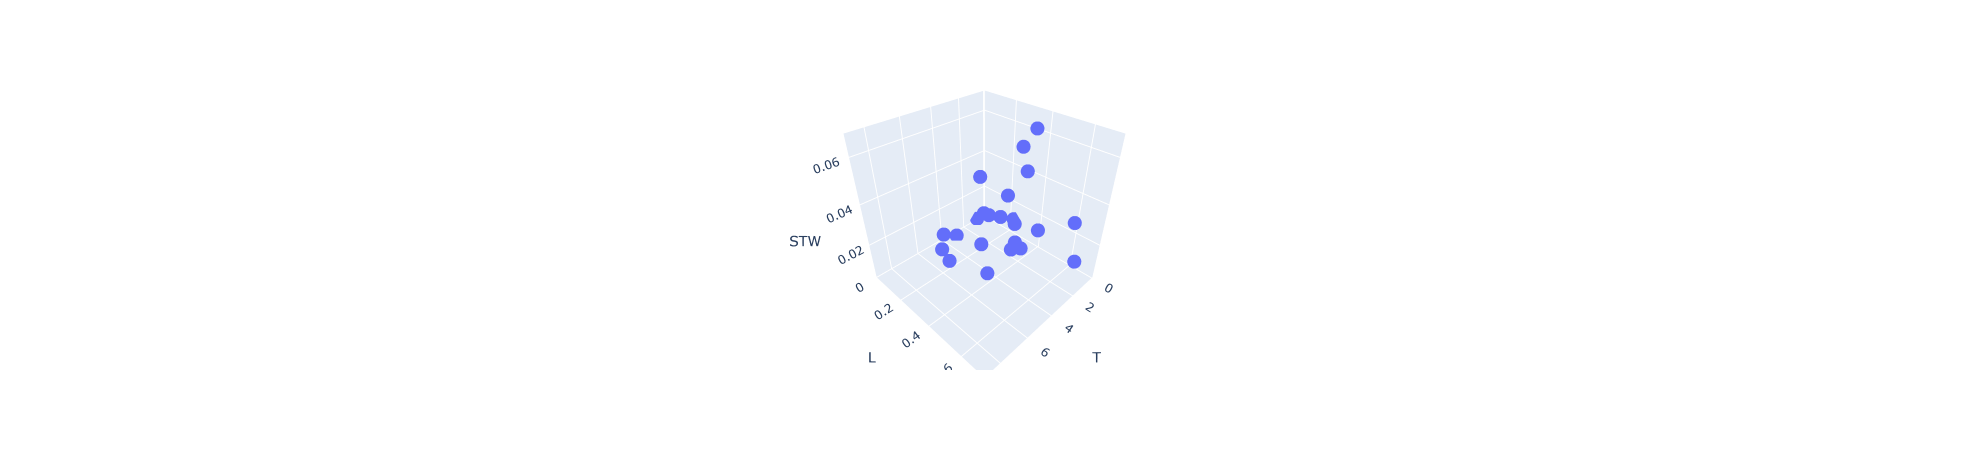

In [66]:
# plot stw/t/l
fig = px.scatter_3d(df, x='T', y='L', z='STW', hover_name='ISSUANCE')
fig.show()

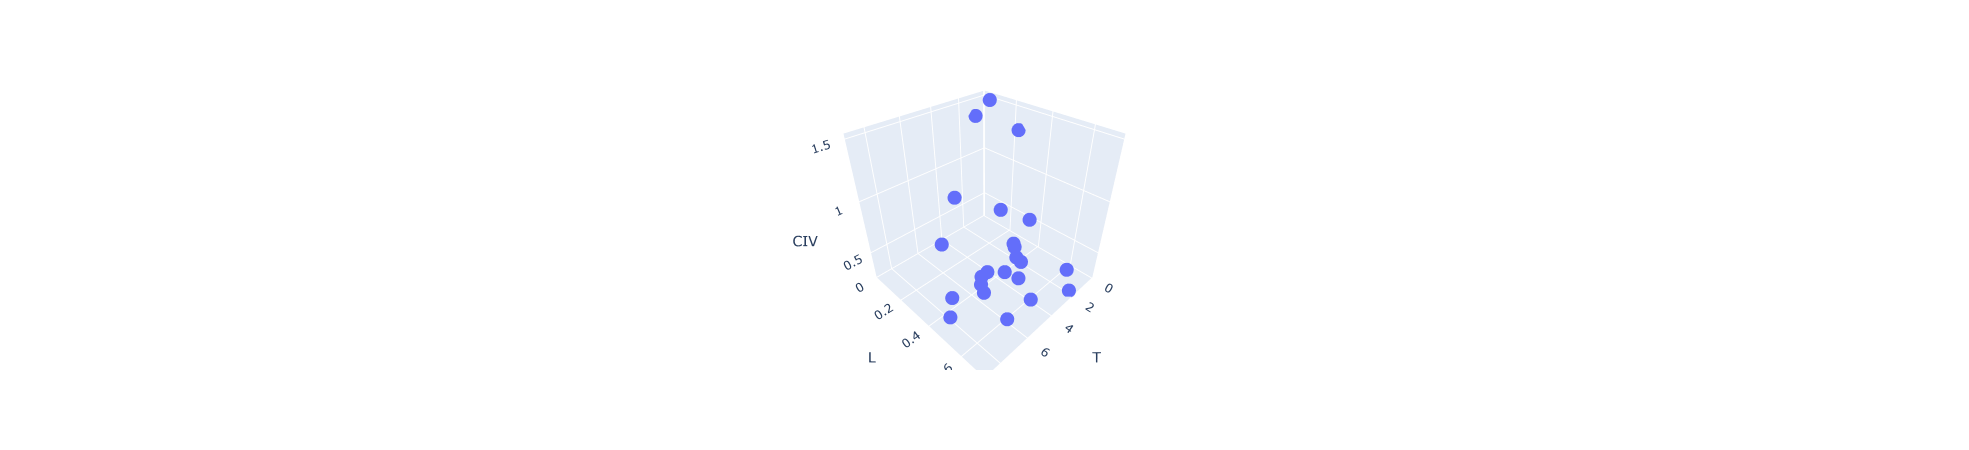

In [68]:
# plot civ
df['CIV'] = est_civ(df.STW, df.L, df['T'])
fig = px.scatter_3d(df, x='T', y='L', z='CIV', hover_name='ISSUANCE')
fig.show()

In [71]:
# standardize data for RF
mus = df[['T', 'L']].mean(axis=0)
stds = df[['T', 'L']].std(axis=0)
X = (df[['T', 'L']]-mus)/stds
Y = df.CIV

In [74]:
# rf regressor
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, Y)
regr.score(X, Y)

0.9035773139600468

In [77]:
# generate predictions and find outliers
preds = regr.predict(X)
errs = preds-Y
z_score_errs = (errs-errs.mean())/errs.std()
df['ZSCORE'] = z_score_errs
df[z_score_errs.abs() >= 1.5]

,ISSUANCE,STW,T,L,CIV,ZSCORE
6,NVDA 2.2% due 2021,0.004237,0.955556,0.020739,1.363756,-2.442754
7,SLG 3.25% due 2022,0.019803,2.036111,0.703215,0.258525,1.540590
21,VZ 3.376% due 2025,0.004196,4.369444,0.370677,0.283032,1.917513
22,CLI 4.5% due 2022,0.066140,1.544444,0.423090,0.675822,-1.537175


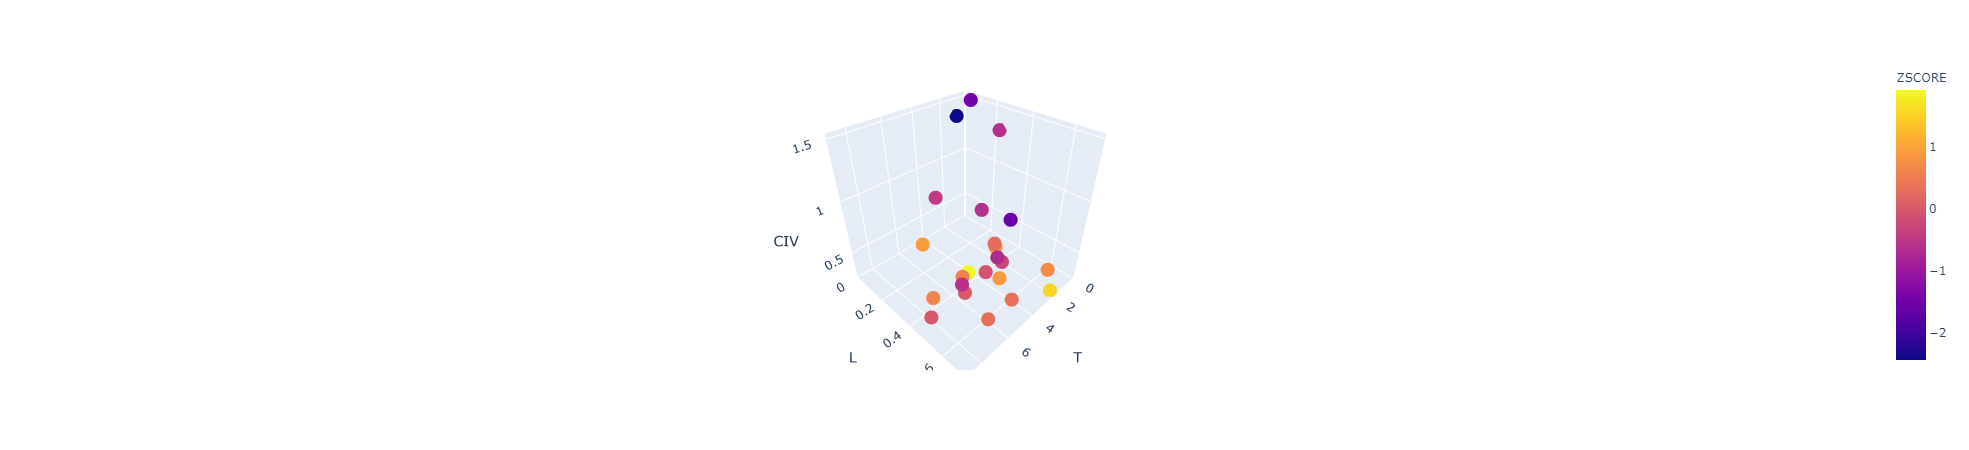

In [78]:
fig = px.scatter_3d(df, x='T', y='L', z='CIV', hover_name='ISSUANCE', color='ZSCORE')
fig.show()